sentiment train dtype: float64


2023-06-12 18:28:29.432532: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-12 18:28:29.433458: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-12 18:28:29.433597: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Yass): /proc/driver/nvidia/version does not exist
2023-06-12 18:28:29.437914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 119, 1)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 119, 3)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 10)           480         ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 3)           0           ['input_2[0][0]']                
 ingOpLambda)                                                                                 

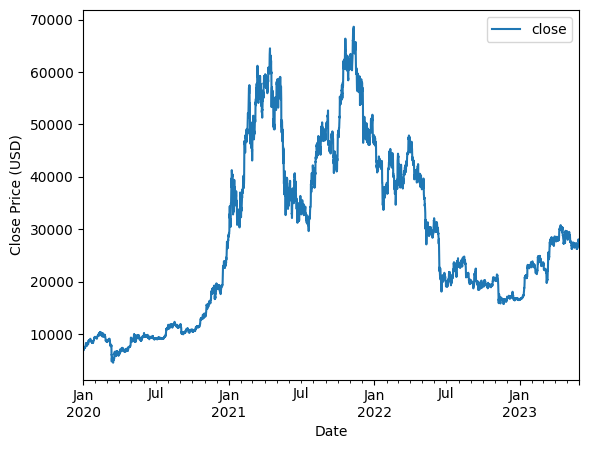

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential, Model
import random
import sklearn
from tensorflow.keras.regularizers import L1L2

# Read the data from a CSV file
url = "/home/yass/code/yass2803/cryptoteller/data/BTCUSDT.csv"
df = pd.read_csv(url)
df.head()

# Change the time unit of the "open_time" column
df["open_time"] = pd.to_datetime(df["open_time"], unit='ms', origin='unix')
df = df.drop(columns=["close_time"])

df.shape

# Plot the closing price over time
ax = df.plot(x='open_time', y='close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization
scaler = MinMaxScaler()
close_price = df.close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

scaled_close.shape

np.isnan(scaled_close).any()


a=["no", "neutral", "yes"]#THIS SIMULATES THE SENTIMENT DATA, TODO: REPLACE WITH REAL SENTIMENT DATA
sentiment = np.array(random.choices(a, k=len(df))).reshape(-1, 1)
OHE_encoder=sklearn.preprocessing.OneHotEncoder()
OHE_sentiment=OHE_encoder.fit_transform(sentiment).toarray()


# Preprocessing
class Preprocessor:
    def __init__(self, SEQ_LEN=120):
        self.SEQ_LEN=SEQ_LEN
        pass
    def to_sequences(self, data,sentiment, seq_len):
        d = []
        s=[]

        for index in range(len(data) - seq_len):
            d.append(data[index: index + seq_len])
            s.append(sentiment[index:index+seq_len])

        return np.array(d), np.array(s)

    def preprocess(self, data_raw,sentiment, train_split):

        data, sentiment = self.to_sequences(data_raw, sentiment, self.SEQ_LEN)

        self.num_train = int(train_split * data.shape[0])

        X_train = data[:self.num_train, :-1, :]
        y_train = data[:self.num_train, -1, :]
        sentiment_train=sentiment[:self.num_train, :-1, :]

        X_test = data[self.num_train:, :-1, :]
        y_test = data[self.num_train:, -1, :]
        sentiment_test=sentiment[self.num_train:, :-1, :]

        return X_train, y_train, X_test, y_test, sentiment_train, sentiment_test

preprocessor=Preprocessor()
X_train, y_train, X_test, y_test, sentiment_train, sentiment_test = preprocessor.preprocess(scaled_close,OHE_sentiment, train_split = 0.80)

print(f"sentiment train dtype: {sentiment_train.dtype}")

X_train.shape
X_test.shape

# Model

DROPOUT = 0.2
WINDOW_SIZE = preprocessor.SEQ_LEN - 1



def init_model(WINDOW_SIZE, dropout, loss, optimizer, metrics):

    inputs_price = keras.Input(shape=(WINDOW_SIZE, 1))
    inputs_sentiment = keras.Input(shape=(WINDOW_SIZE,3)) 
    hidden_lstm=LSTM(10, return_sequences=False, kernel_regularizer=L1L2(l1=0.05, l2=0.05))(inputs_price)

    concat = keras.layers.concatenate([hidden_lstm, inputs_sentiment[:, -1, :]], -1)
    hidden_final=keras.layers.Dense(32)(concat)
    output=keras.layers.Dense(1)(hidden_final)
    model = Model(inputs=[inputs_price, inputs_sentiment], outputs=output)

    print(model.summary())
    return model




model=init_model(WINDOW_SIZE, DROPOUT, 'mean_squared_error', 'adam', ["mae"])
# Training
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

es = EarlyStopping(monitor="val_loss",
                       patience=3,
                       mode="min",
                       restore_best_weights=True)

 
model.compile(
    loss='mean_squared_error',
    metrics=["mae"] ,
    optimizer="adam"
)

BATCH_SIZE = 64





In [5]:
history = model.fit(
    [X_train, sentiment_train],
    y_train,
    epochs=6,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/6
55/55 [==============================] - 6s 74ms/step - loss: 0.4877 - mae: 0.1781 - val_loss: 0.4701 - val_mae: 0.3213
Epoch 2/6
55/55 [==============================] - 4s 66ms/step - loss: 0.3895 - mae: 0.2393 - val_loss: 0.3363 - val_mae: 0.2796
Epoch 3/6
55/55 [==============================] - 4s 64ms/step - loss: 0.2630 - mae: 0.1795 - val_loss: 0.2099 - val_mae: 0.1644
Epoch 4/6
55/55 [==============================] - 4s 64ms/step - loss: 0.1715 - mae: 0.1086 - val_loss: 0.1279 - val_mae: 0.0770
Epoch 5/6
55/55 [==============================] - 3s 63ms/step - loss: 0.1095 - mae: 0.0834 - val_loss: 0.0805 - val_mae: 0.0706
Epoch 6/6
55/55 [==============================] - 4s 68ms/step - loss: 0.0720 - mae: 0.0860 - val_loss: 0.0517 - val_mae: 0.0803


31/31 [==============================] - 0s 14ms/step - loss: 0.0512 - mae: 0.0735
MAE for the test set: 9276.080842398256


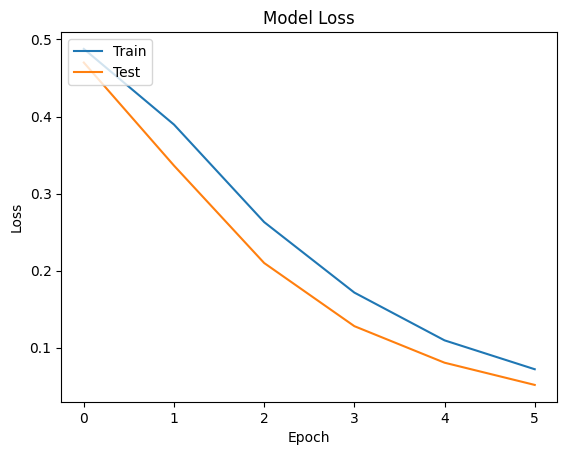

31/31 [==============================] - 1s 14ms/step


<module 'matplotlib.pyplot' from '/home/yass/.pyenv/versions/lewagon/lib/python3.10/site-packages/matplotlib/pyplot.py'>

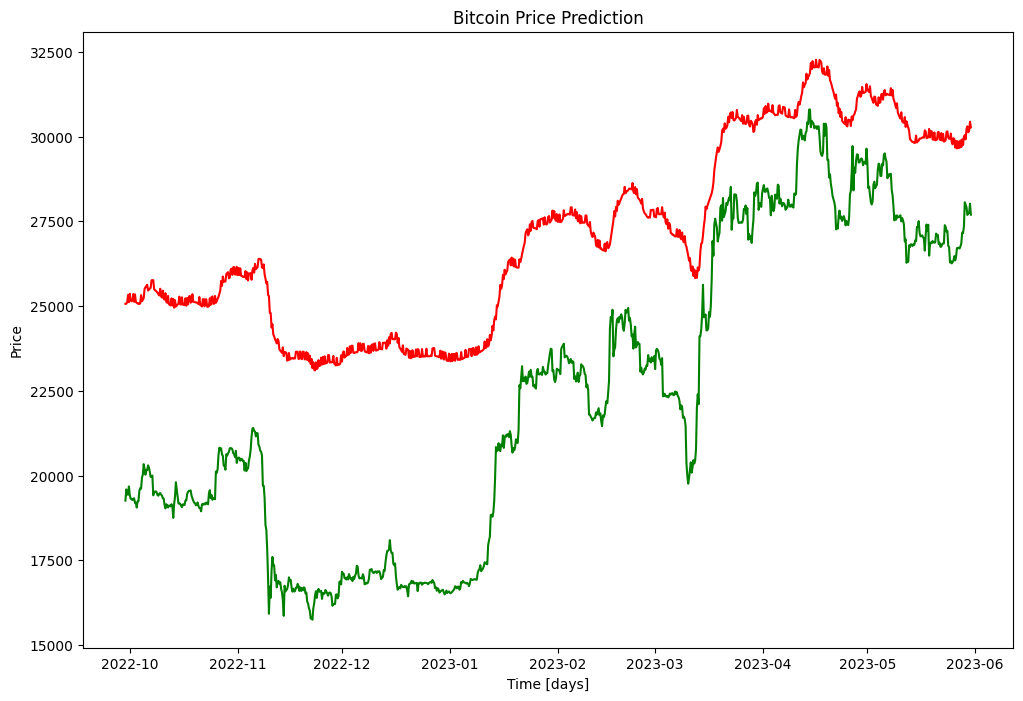

In [6]:
# Evaluation
MAE=scaler.inverse_transform([[model.evaluate([X_test, sentiment_test], y_test)[1]]])[0][0]
print(f"MAE for the test set: {MAE}")

# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction
y_hat = model.predict([X_test, sentiment_test])
# Inverse transform the scaled data to get the actual prices
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

# Plot the actual and predicted prices
# Prediction
date_time_test = df.iloc[preprocessor.num_train + preprocessor.SEQ_LEN:, 0].to_numpy()

# Plot the actual and predicted prices
plt.figure(figsize=(12, 8))  # Set the figure size to make it larger
plt.plot(date_time_test, y_test_inverse, label="Actual Price", color='green')
plt.plot(date_time_test, y_hat_inverse, label="Predicted Price", color='red')

# Customize the plot
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt


31/31 [==============================] - 0s 15ms/step - loss: 0.0512 - mae: 0.0735
MAE for the test set: 9276.080842398256


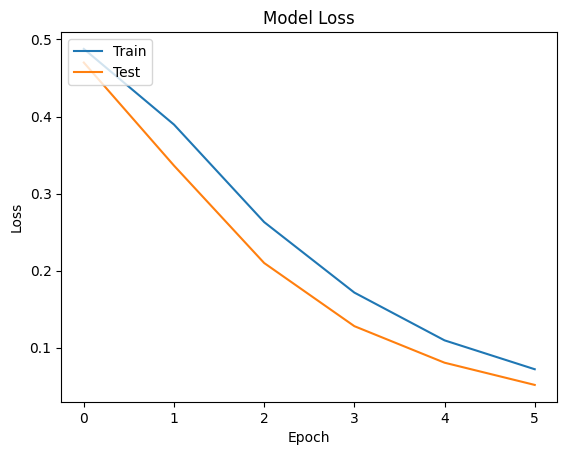

31/31 [==============================] - 0s 14ms/step
[[0.32000643]
 [0.32002145]
 [0.32067463]
 [0.32407054]
 [0.320752  ]
 [0.32464224]
 [0.32151705]
 [0.32119545]
 [0.32138836]
 [0.32447812]
 [0.32092357]
 [0.32433978]
 [0.32091534]
 [0.32045075]
 [0.32010394]
 [0.32026476]
 [0.31991002]
 [0.32018444]
 [0.32402065]
 [0.32113805]
 [0.32182503]
 [0.32256785]
 [0.32682607]
 [0.32763445]
 [0.3281696 ]
 [0.32879856]
 [0.32613853]
 [0.32651752]
 [0.32702214]
 [0.32730648]
 [0.33083498]
 [0.330862  ]
 [0.33089444]
 [0.3267552 ]
 [0.32624188]
 [0.32599226]
 [0.32553762]
 [0.3250791 ]
 [0.32430187]
 [0.3238286 ]
 [0.32694772]
 [0.3234497 ]
 [0.32288224]
 [0.32606387]
 [0.32251078]
 [0.3219311 ]
 [0.32491013]
 [0.32087532]
 [0.32050976]
 [0.3236357 ]
 [0.31977734]
 [0.31950232]
 [0.31926736]
 [0.322516  ]
 [0.3191907 ]
 [0.32223347]
 [0.31822938]
 [0.32168803]
 [0.31873354]
 [0.31921938]
 [0.31969622]
 [0.32014087]
 [0.3232954 ]
 [0.31975904]
 [0.31968   ]
 [0.3230032 ]
 [0.31960216]
 [0.3195

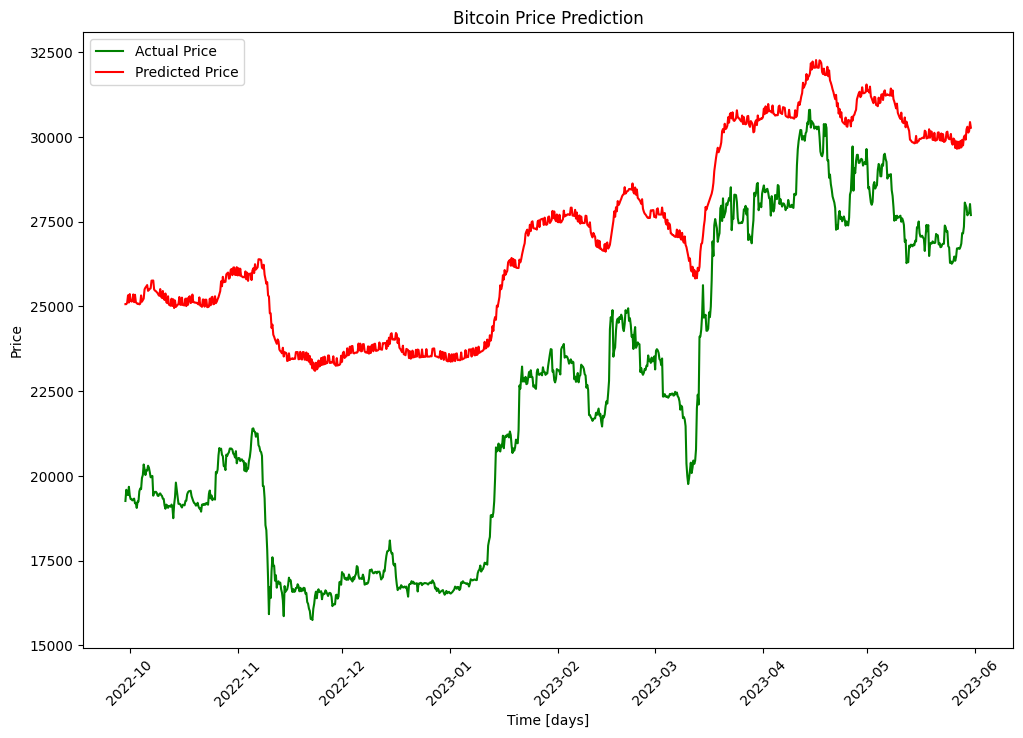

In [7]:

# Evaluation
MAE=scaler.inverse_transform([[model.evaluate([X_test, sentiment_test], y_test)[1]]])[0][0]
print(f"MAE for the test set: {MAE}")

# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction
y_hat = model.predict([X_test, sentiment_test])
print(y_hat)
# Inverse transform the scaled data to get the actual prices
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

# Plot the actual and predicted prices
# Prediction


date_time_test = df.iloc[preprocessor.num_train + preprocessor.SEQ_LEN:, 0].to_numpy()

# Plot the actual and predicted prices
plt.figure(figsize=(12, 8))  # Set the figure size to make it larger
plt.plot(date_time_test, y_test_inverse, label="Actual Price", color='green')
plt.plot(date_time_test, y_hat_inverse, label="Predicted Price", color='red')

# Customize the plot
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees for better readability
plt.legend(loc='best')

plt.show()


In [ ]:
len(df)

4984

In [ ]:
a.sum()

2442

In [ ]:
a=["no", "neutral", "yes"]
import random
np.array(random.choices(a, k=len(df))).reshape(-1,1)

array([['yes'],
       ['no'],
       ['neutral'],
       ...,
       ['yes'],
       ['neutral'],
       ['no']], dtype='<U7')

In [ ]:
sentiment_test

array([[[0],
        [2],
        [2],
        ...,
        [0],
        [0],
        [0]],

       [[2],
        [2],
        [0],
        ...,
        [0],
        [0],
        [2]],

       [[2],
        [0],
        [0],
        ...,
        [0],
        [2],
        [0]],

       ...,

       [[1],
        [1],
        [2],
        ...,
        [0],
        [1],
        [2]],

       [[1],
        [2],
        [2],
        ...,
        [1],
        [2],
        [0]],

       [[2],
        [2],
        [1],
        ...,
        [2],
        [0],
        [0]]])